<a href="https://colab.research.google.com/github/Juliaroch/Ironhack-Module-1-Project---Pipelines-Julia-Roch-/blob/master/Training_CNN_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib 
import matplotlib.pyplot as plt
import random 
import numpy as np
import tensorflow as tf

In [2]:
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.optimizers import RMSprop, SGD
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
#Import the images from 11 artists I need for my training
images_dir = '/content/gdrive/My Drive/Final_project_data/resized_train_test'
data_artists = pd.read_csv('/content/gdrive/My Drive/Final_project_data/data_artists.csv')
artists_dirs = os.listdir(images_dir)
artists_top_name = data_artists['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))


Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Vincent_van_Gogh
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Pablo_Picasso
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Pierre-Auguste_Renoir
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Francisco_Goya
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Albrecht_Dürer
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Alfred_Sisley
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Marc_Chagall
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Edgar_Degas
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Rembrandt
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Titian
Found --> /content/gdrive/My Drive/Final_project_data/resized_train_test/Paul_Gauguin


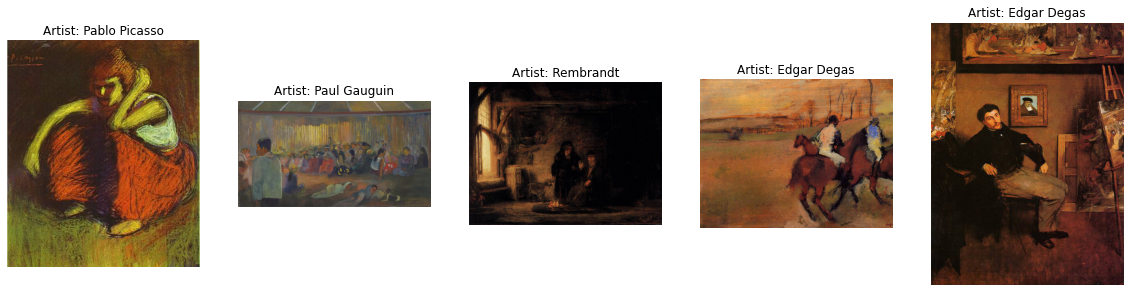

In [5]:
#See if images have been imported correctly 
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [6]:
#Train_test_split
batch_size = 16
train_input_shape = (128, 128, 3)
n_classes = artists_top_name.shape[0]

train_datagen=ImageDataGenerator(validation_split=0.1,rescale=1./255.,horizontal_flip=True,vertical_flip=True)
                                 
train_generator=train_datagen.flow_from_directory(directory=images_dir,class_mode='categorical',target_size=train_input_shape[0:2],batch_size=batch_size,subset="training",shuffle=True,classes=artists_top_name.tolist())
                                                   
valid_generator=train_datagen.flow_from_directory(directory=images_dir,class_mode='categorical',target_size=train_input_shape[0:2],batch_size=batch_size,subset="validation",shuffle=True,classes=artists_top_name.tolist())

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 2384 images belonging to 11 classes.
Found 262 images belonging to 11 classes.
Total number of batches = 149 and 16


In [7]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=train_input_shape)

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have n_classes classes
output = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)

optimizer = tf.keras.optimizers.RMSprop(lr=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
n_epoch = 16

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')

In [11]:
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID, epochs=n_epoch, shuffle=True, verbose=1, callbacks=[reduce_lr], use_multiprocessing=True, workers=16)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/16
149/149 [==============================] - 61s 407ms/step - loss: 1.1253 - accuracy: 0.8779 - val_loss: 3.9865 - val_accuracy: 0.1836 - lr: 0.0010
Epoch 2/16
149/149 [==============================] - 58s 391ms/step - loss: 0.4803 - accuracy: 0.9052 - val_loss: 2.7453 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 3/16
149/149 [==============================] - 63s 420ms/step - loss: 0.4223 - accuracy: 0.9178 - val_loss: 2.2860 - val_accuracy: 0.4336 - lr: 0.0010
Epoch 4/16
149/149 [==============================] - 61s 409ms/step - loss: 0.4354 - accuracy: 0.9186 - val_loss: 4.1713 - val_accuracy: 0.3711 - lr: 0.0010
Epoch 5/16
149/149 [==============================] - 58s 392ms/step - loss: 0.3463 - accuracy: 0.9320 - val_loss: 3.5455 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 6/16
149/149 [==============================] - 65s 438ms/step - loss: 0.2845 - accuracy: 0.9358 - val_loss: 2.6983 - val_accura

In [12]:
for layer in model.layers[:249]:
   layer.trainable = False

for layer in model.layers[249:]:
   layer.trainable = True

#from keras.optimizers import SGD

tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

model.compile(optimizer='SGD', loss='categorical_crossentropy',metrics=['accuracy'])

n_epoch = 20
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID, epochs=n_epoch, shuffle=True, verbose=1, callbacks=[reduce_lr, early_stop], use_multiprocessing=True, workers=16)

Epoch 1/20
149/149 [==============================] - 20s 133ms/step - loss: 0.1501 - accuracy: 0.9597 - val_loss: 1.2140 - val_accuracy: 0.4906 - lr: 0.0100
Epoch 2/20
149/149 [==============================] - 19s 127ms/step - loss: 0.1339 - accuracy: 0.9648 - val_loss: 1.7001 - val_accuracy: 0.4492 - lr: 0.0100
Epoch 3/20
149/149 [==============================] - 19s 125ms/step - loss: 0.1177 - accuracy: 0.9664 - val_loss: 1.7086 - val_accuracy: 0.3945 - lr: 0.0100
Epoch 4/20
149/149 [==============================] - 19s 128ms/step - loss: 0.1200 - accuracy: 0.9639 - val_loss: 0.8229 - val_accuracy: 0.7969 - lr: 0.0100
Epoch 5/20
149/149 [==============================] - 19s 128ms/step - loss: 0.1077 - accuracy: 0.9673 - val_loss: 1.2465 - val_accuracy: 0.6172 - lr: 0.0100
Epoch 6/20
149/149 [==============================] - 19s 130ms/step - loss: 0.1161 - accuracy: 0.9685 - val_loss: 1.9840 - val_accuracy: 0.3750 - lr: 0.0100
Epoch 7/20
149/149 [==============================] 

In [13]:
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

KeyboardInterrupt: ignored

In [0]:
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


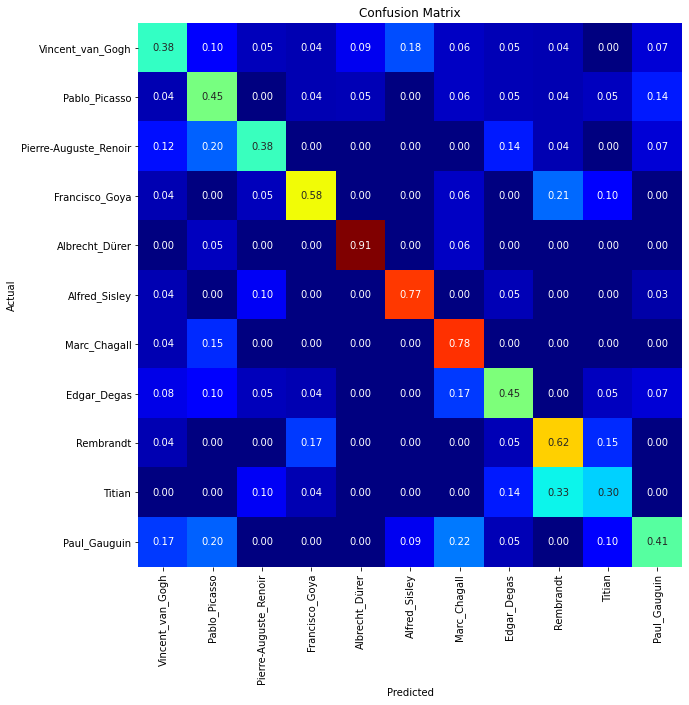

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.39      0.38      0.38        24
        Pablo_Picasso       0.36      0.45      0.40        20
Pierre-Auguste_Renoir       0.53      0.38      0.44        21
       Francisco_Goya       0.64      0.58      0.61        24
       Albrecht_Dürer       0.87      0.91      0.89        22
        Alfred_Sisley       0.74      0.77      0.76        22
         Marc_Chagall       0.56      0.78      0.65        18
          Edgar_Degas       0.48      0.45      0.47        22
            Rembrandt       0.48      0.62      0.55        24
               Titian       0.40      0.30      0.34        20
         Paul_Gauguin       0.52      0.41      0.46        29

             accuracy                           0.54       246
            macro avg       0.54      0.55      0.54       246
         weighted avg       0.54      0.54      0.54       246



In [14]:
 # Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)